## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Error importing in API mode: ImportError("dlopen(/Users/wongpeiting/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/wongpeiting/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [6]:
%%R 

library(sf)
library(tigris)

# TOPIC: Poverty Rates in NYC
#
# Table B17001: Poverty Status in the Past 12 Months
# - B17001_001: Total population for whom poverty status is determined
# - B17001_002: Population with income below poverty level
#
# Source: https://censusreporter.org/tables/B17001/

nyc_census_data <- get_acs(
  geography = "tract",
  state = "NY",
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    population = "B01003_001",        # Total population
    poverty_universe = "B17001_001",  # Population for whom poverty is determined
    poverty_below = "B17001_002"      # Population below poverty level
  ),
  year = 2021,
  survey = "acs5",
  geometry = TRUE
)

nyc_census_data

Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME         variable
1  36081014700  Census Tract 147, Queens County, New York       population
2  36081014700  Census Tract 147, Queens County, New York poverty_universe
3  36081014700  Census Tract 147, Queens County, New York    poverty_below
4  36047058400   Census Tract 584, Kings County, New York       population
5  36047058400   Census Tract 584, Kings County, New York poverty_universe
6  36047058400   Census Tract 584, Kings County, New York    poverty_below
7  36061006900 Census Tract 69, New York County, New York       population
8  36061006900 Census Tract 69, New York County, New York poverty_universe
9  36061006900 Census Tract 69, New York County, New York    poverty_below
10 3

Linking to GEOS 3.14.1, GDAL 3.12.2, PROJ 9.7.1; sf_use_s2() is TRUE
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.
Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [7]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from = variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

# Check the structure
nyc_census_data %>%
  st_drop_geometry() %>%
  head()

# A tibble: 6 × 8
  GEOID  NAME  population_estimate poverty_universe_est…¹ poverty_below_estimate
  <chr>  <chr>               <dbl>                  <dbl>                  <dbl>
1 36081… Cens…                2863                   2862                    165
2 36047… Cens…                3655                   3655                    232
3 36061… Cens…                2450                   2126                     89
4 36047… Cens…                2676                   2675                     49
5 36047… Cens…                3004                   3004                    242
6 36047… Cens…                1834                   1834                    141
# ℹ abbreviated name: ¹​poverty_universe_estimate
# ℹ 3 more variables: population_moe <dbl>, poverty_universe_moe <dbl>,
#   poverty_below_moe <dbl>


### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [8]:
%%R 

# Calculate poverty rate and extract borough name
nyc_census_data <- nyc_census_data %>% 
  mutate(
    # Poverty rate = people below poverty / total for whom poverty is determined
    poverty_rate = (poverty_below_estimate / poverty_universe_estimate) * 100,
    
    # Extract borough name from the NAME column
    # NAME looks like "Census Tract 147, Queens County, New York"
    borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
  ) %>%
  # Remove tracts with missing data
  filter(!is.na(poverty_rate), is.finite(poverty_rate))

# Summary statistics
cat("Poverty Rate Summary (%):\n")
summary(nyc_census_data$poverty_rate)

cat("\nNumber of tracts by borough:\n")
nyc_census_data %>%
  st_drop_geometry() %>%
  count(borough)

Poverty Rate Summary (%):

Number of tracts by borough:
# A tibble: 5 × 2
  borough             n
  <chr>           <int>
1 Bronx County      345
2 Kings County      777
3 New York County   302
4 Queens County     690
5 Richmond County   121


### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

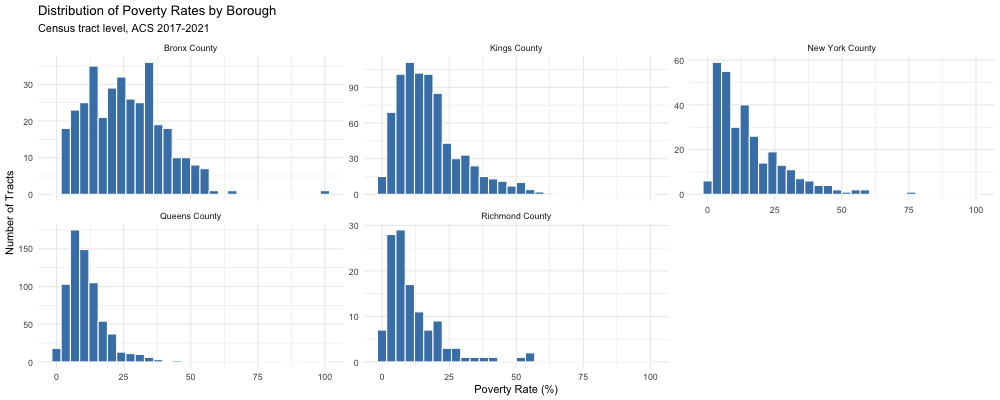

In [9]:
%%R -w 1000 -h 400

# Histogram of poverty rates by borough
ggplot(nyc_census_data) +
  aes(x = poverty_rate) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  facet_wrap(~borough, scales = "free_y") +
  labs(
    title = "Distribution of Poverty Rates by Borough",
    subtitle = "Census tract level, ACS 2017-2021",
    x = "Poverty Rate (%)",
    y = "Number of Tracts"
  ) +
  theme_minimal()

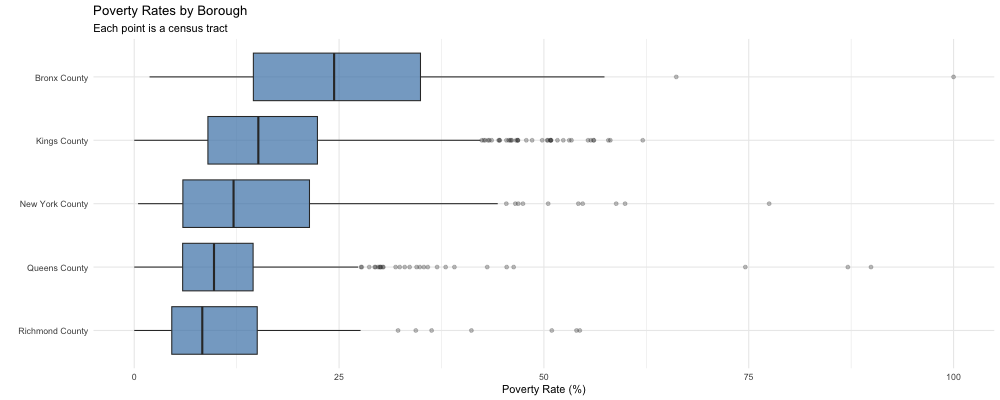

In [10]:
%%R -w 1000 -h 400

# Boxplot comparison across boroughs
ggplot(nyc_census_data) +
  aes(x = poverty_rate, y = reorder(borough, poverty_rate, FUN = median)) +
  geom_boxplot(fill = "steelblue", alpha = 0.7, outlier.alpha = 0.3) +
  labs(
    title = "Poverty Rates by Borough",
    subtitle = "Each point is a census tract",
    x = "Poverty Rate (%)",
    y = ""
  ) +
  theme_minimal()

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


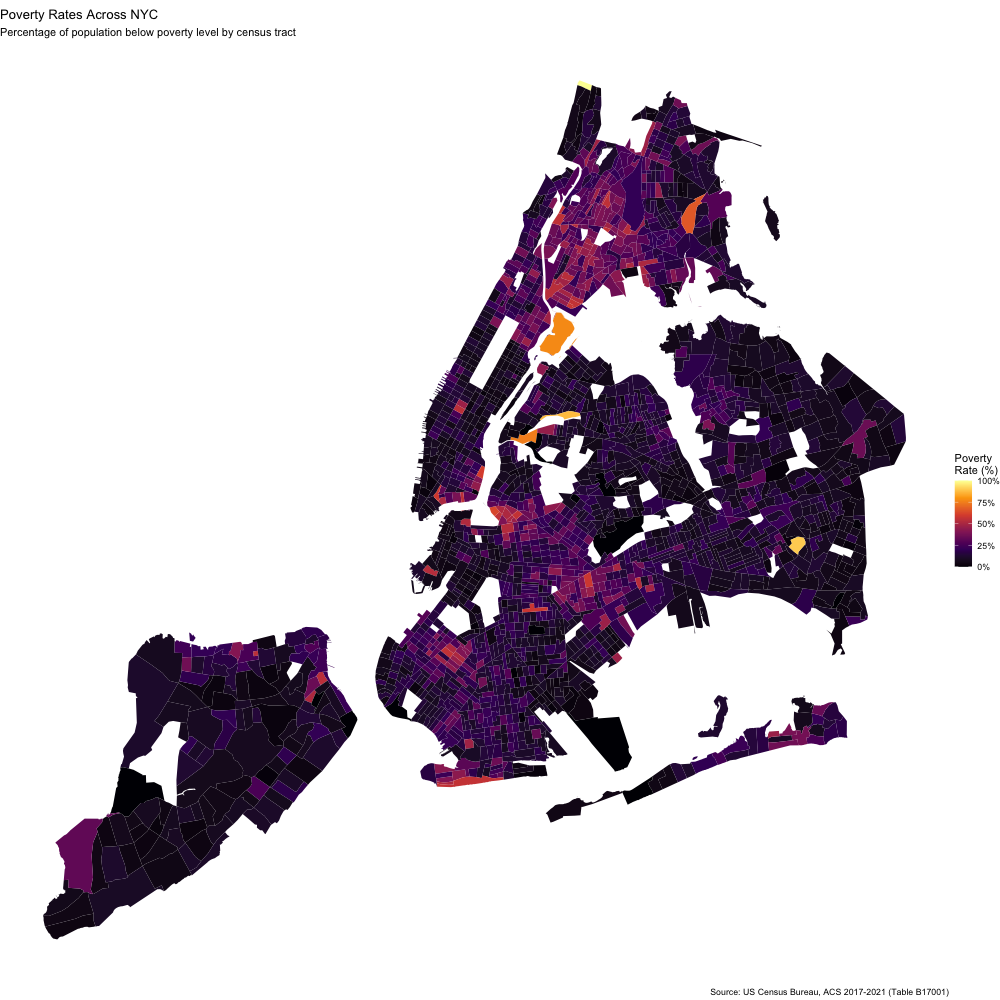

In [11]:
%%R -w 1000 -h 1000

# Remove water areas so rivers show on the map
nyc_census_data <- nyc_census_data %>% erase_water()

# Choropleth map of poverty rates
ggplot(nyc_census_data) +
  geom_sf(aes(fill = poverty_rate), color = NA) +
  scale_fill_viridis_c(
    option = "inferno",
    name = "Poverty\nRate (%)",
    labels = function(x) paste0(round(x), "%")
  ) +
  theme_void() +
  labs(
    title = "Poverty Rates Across NYC",
    subtitle = "Percentage of population below poverty level by census tract",
    caption = "Source: US Census Bureau, ACS 2017-2021 (Table B17001)"
  )